In [40]:
using LinearAlgebra
using BenchmarkTools, Statistics
import PyPlot

In [83]:
powers = 2:12
svd_mem    = zeros(size(powers))
svd_times   = zeros(size(powers))
gebrd_mem  = zeros(size(powers))
gebrd_times = zeros(size(powers))

for (i, p) in enumerate(powers)
    print("\rBenchmarking p=$(p)...")
    N = 2^p

    A = rand(N, N)
    b_svdvals = @benchmark svdvals!($A)

    svd_mem[i] = b_svdvals.memory
    svd_times[i] = median(b_svdvals.times) / 1e9

    A = rand(N, N)
    b_gebrd = @benchmark LAPACK.gebrd!($A)

    gebrd_mem[i] = b_gebrd.memory
    gebrd_times[i] = median(b_gebrd.times) / 1e9
end

Benchmarking p=12...

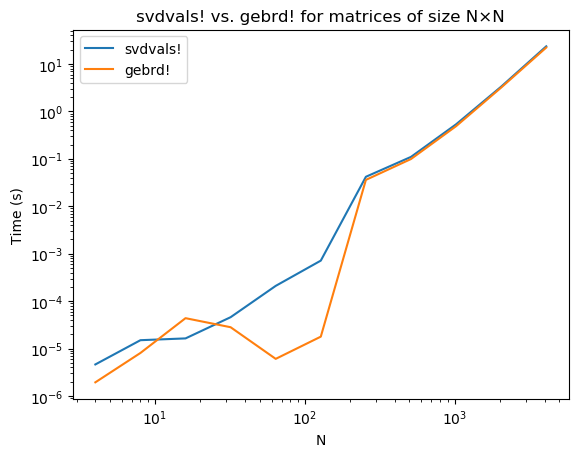

In [84]:
PyPlot.loglog(2 .^ powers, svd_times, label="svdvals!");
PyPlot.loglog(2 .^ powers, gebrd_times, label="gebrd!");
PyPlot.title("svdvals! vs. gebrd! for matrices of size N×N")
PyPlot.xlabel("N")
PyPlot.ylabel("Time (s)")
PyPlot.legend();

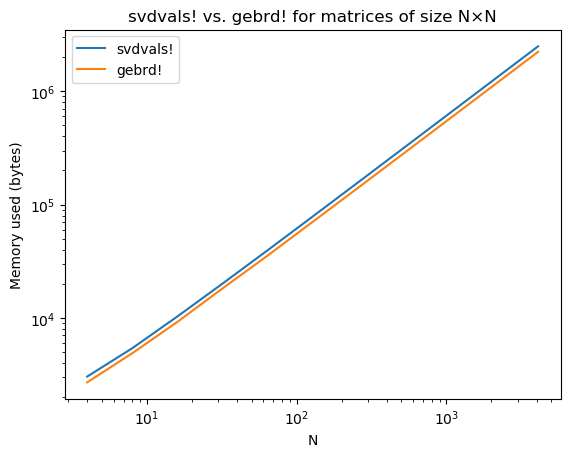

In [85]:
PyPlot.loglog(2 .^ powers, svd_mem, label="svdvals!");
PyPlot.loglog(2 .^ powers, gebrd_mem, label="gebrd!");
PyPlot.title("svdvals! vs. gebrd! for matrices of size N×N")
PyPlot.xlabel("N")
PyPlot.ylabel("Memory used (bytes)")
PyPlot.legend();

In [ ]:
# lu.jl
using LinearAlgebra
using Elemental
using BenchmarkTools

Elemental.Init()

N = parse(Int, ARGS[1])

A = Elemental.DistMatrix(Float64)
Elemental.gaussian!(A, N, N)

@time Elemental.lu(A)

Elemental.Finalize()

In [ ]:
# time_lu.bash
#!/bin/bash
for p in `seq 2 15`; do
    echo N=`echo 2^$p | bc`
    time mpirun -np 28 julia lu.jl `echo 2^$p | bc`
done

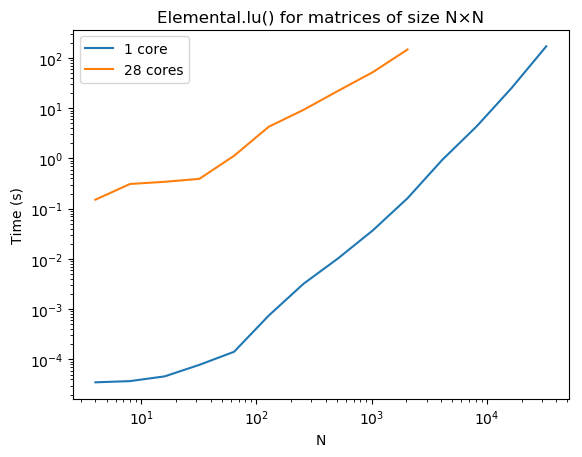

In [101]:
# Timing on a 28-core Intel Xeon CPU E5-2680 v4 @ 2.40GHz with 125 GiB of memory on the engaging cluster.

N = [4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768]
lu_time28 = [0.151145, 0.310489, 0.342972, 0.392684, 1.130295, 4.280525, 9.261132, 22.197493, 52.178783, 147.410254]
lu_time1  = [0.000035, 0.000037, 0.000046, 0.000078, 0.000142, 0.000747, 0.003196, 0.010280, 0.037031, 0.161393, 0.935107, 4.400922, 25.218458, 170.574021]

PyPlot.loglog(N, lu_time1, label="1 core")
PyPlot.loglog(N[1:length(lu_time28)], lu_time28, label="28 cores")
PyPlot.title("Elemental.lu() for matrices of size N×N")
PyPlot.xlabel("N")
PyPlot.ylabel("Time (s)")
PyPlot.legend();

For some reason, MPI with 28 cores was SOOO MUCH slower. My guess is that maybe I had a bad MPI set up or something, or maybe 28 cores was not a good choice? Communication overhead was obviously dominant. 

In [ ]:
# svd.jl
using LinearAlgebra
using Elemental
using BenchmarkTools

Elemental.Init()

N = parse(Int, ARGS[1])

A = Elemental.DistMatrix(Float64)
Elemental.gaussian!(A, N, N)

@time svdvals(A)

Elemental.Finalize()

In [ ]:
# time_svd.bash
#!/bin/bash
for p in `seq 2 12`; do
    echo N=`echo 2^$p | bc`
    time mpirun -np 28 julia svd.jl `echo 2^$p | bc`
done

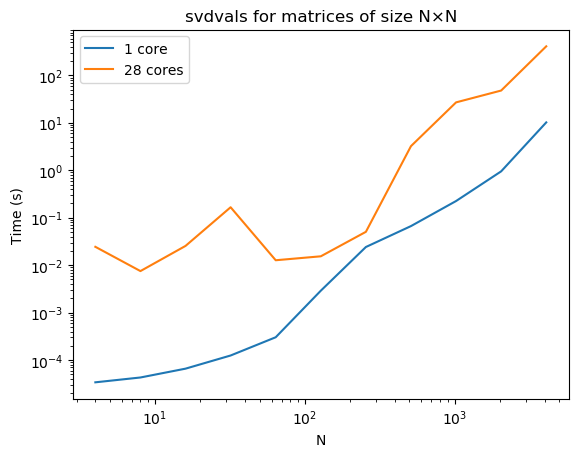

In [96]:
# Timing on a 28-core Intel Xeon CPU E5-2680 v4 @ 2.40GHz with 125 GiB of memory on the engaging cluster. Using openmpi 2.0.3.

N = [4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096]
svd_time28 = [0.024424, 0.007519, 0.025511, 0.166568, 0.012722, 0.015401, 0.050539, 3.235559, 27.058002, 48.046218, 410.87521]
svd_time1  = [0.000034, 0.000043, 0.000066, 0.000125, 0.000303, 0.002902, 0.024195, 0.066791, 0.225350, 0.951586, 10.240202]

PyPlot.loglog(N, svd_time1, label="1 core")
PyPlot.loglog(N, svd_time28, label="28 cores")
PyPlot.title("svdvals for matrices of size N×N")
PyPlot.xlabel("N")
PyPlot.ylabel("Time (s)")
PyPlot.legend();

Again for some reason, MPI with 28 cores was SOOO MUCH slower. My guess is that maybe I had a bad MPI set up or something, or maybe 28 cores was not a good choice? Communication overhead was obviously dominant. 